JG 4/18/18
This workbook is for comparing BD across depth vs. BD between defining soil types.

In [229]:
import itertools
import pandas as pd
import numpy as np
from skbio import stats
import skbio
import scipy.stats as scipystats

print(skbio.__version__)
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
%matplotlib inline

# Importing colors with palettable:
from palettable.colorbrewer.qualitative import Set1_3
new_cols = [[x/255.0 for x in color] for color in Set1_3.colors]
#sns.palplot(new_cols)
#colorbrewer.qualitative import Set2_3

0.4.2


In [55]:
# Standard import:
WUF_data = pd.read_csv('../../Seq_data/Updated_files/beta_WUF_diversity/WUF_dm2.txt', sep='\t',index_col=0)
current_metadata = pd.read_csv('../../Metadata/ibp_metadata_4.17.18.txt', sep='\t')     

### Mantel Tests
Only hard part is converting to distance matrix

In [242]:
# Convert dataframes to distance matrices:
wuf_distmat = skbio.DistanceMatrix(WUF_data)
spatial_distmat = skbio.DistanceMatrix(spatial_dist)
full_mantel = skbio.stats.distance.mantel(wuf_distmat, spatial_distmat)


# Subsets:



(0.18146608710585846, 0.001, 222)

In [238]:
spatial_dist = pd.DataFrame(data = 0, index = WUF_data.index, columns = WUF_data.columns)
for i in spatial_dist.index:
    depth_i = int(i.split('.')[1][1:])
    for j in spatial_dist.columns:
        depth_j = int(j.split('.')[1][1:])
        dist = abs(depth_i - depth_j)
        spatial_dist.loc[i,j] = dist

### Mantel Plot Time (BD vs deltaDepth)
Originally, I felt slightly weird for redoing a figure from another manuscript I made, but then I remembered that Mantel plots are as standard as possible.
*Simple Mantel Plot*: (No categorization for soil type) There is extremely high variability looking at just depth differences. This suggests I should look at a more granular level (For the next version I will plot as a function of same well, same soil type only, and different soil type). 


In [152]:
class mantel_results():
    """Store Mantel Results in BD_by_depth, 
    where the i'th list stores all beta diversties for samples i*10 cm apart in depth
    """
    def __init__(self, depth_inc):
        self.BD_by_depth = [ [] for i in range(depth_inc) ]   
        self.depth_inc = depth_inc
        self.means = []
        self.stds = []
        
    def calc_box_and_whisker(self):
        # Calculates the mean and standard deviation for each deltaDepth
        self.means = []
        self.stds = []
        for i in range(self.depth_inc):
            self.means.append(np.mean(self.BD_by_depth[i]))
            self.stds.append(np.std(self.BD_by_depth[i]))
    
    def calc_fill(self):
        # Uses self.mean and self.std to generate y-values for plotting with fill-between
        self.y1 = [x[0]-x[1] for x in zip(self.means, self.stds)]
        self.y2 = [x[0]+x[1] for x in zip(self.means, self.stds)]
        self.x = list(range(len(y1)))

In [153]:
current_metadata2 = current_metadata.set_index('SampleID')

# Segmenting into 3 groups:
same_well = mantel_results(12)
same_soil = mantel_results(12)
dif_soil = mantel_results(12)

for i in range(1,13):
    for j in range(1+i, 13):
        delta_depth = j-i
        i_samples = current_metadata.loc[current_metadata["MicroNum"] == i, "SampleID"].values.tolist()
        j_samples = current_metadata.loc[current_metadata["MicroNum"] == j, "SampleID"].values.tolist()
        for sample_pair in itertools.product(i_samples, j_samples):
            
            if current_metadata2.loc[sample_pair[0], "WLWNum"] == \
            current_metadata2.loc[sample_pair[1], "WLWNum"]:
                same_well.BD_by_depth[delta_depth].append(WUF_data.loc[sample_pair[0], sample_pair[1]])
            
            elif current_metadata2.loc[sample_pair[0], "USDA_soil_series"] == \
            current_metadata2.loc[sample_pair[1], "USDA_soil_series"]:
                same_soil.BD_by_depth[delta_depth].append(WUF_data.loc[sample_pair[0], sample_pair[1]])
                
            else:
                dif_soil.BD_by_depth[delta_depth].append(WUF_data.loc[sample_pair[0], sample_pair[1]])

In [154]:
same_well.calc_box_and_whisker()
same_soil.calc_box_and_whisker()
dif_soil.calc_box_and_whisker()

same_well.calc_fill()
same_soil.calc_fill()
dif_soil.calc_fill()

/Users/jimbo/anaconda3/envs/skbio_py3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/jimbo/anaconda3/envs/skbio_py3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jimbo/anaconda3/envs/skbio_py3/lib/python3.5/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/jimbo/anaconda3/envs/skbio_py3/lib/python3.5/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/jimbo/anaconda3/envs/skbio_py3/lib/python3.5/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


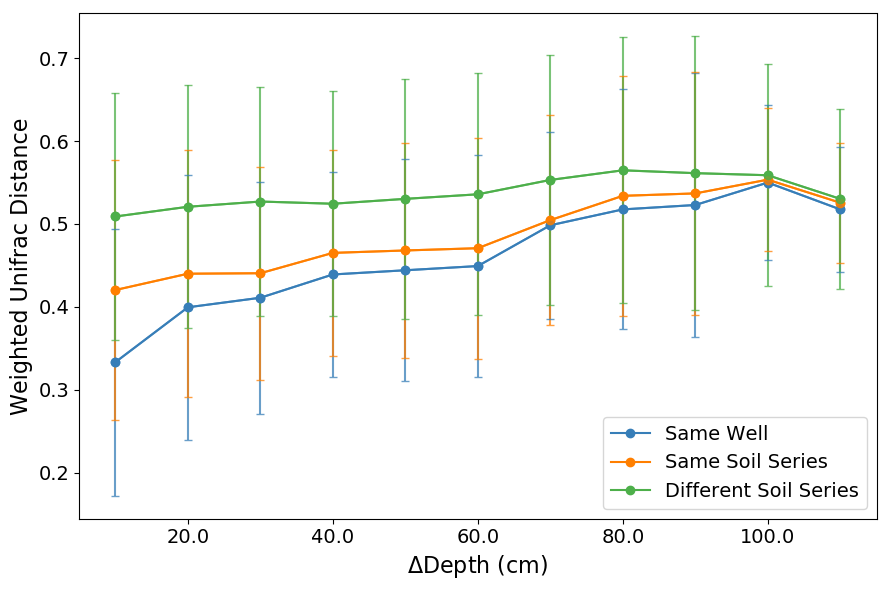

In [228]:
colors = sns.color_palette('Set1')
f,ax = plt.subplots()

ax.errorbar(list(range(1,12)), same_well.means[1:], yerr=same_well.stds[1:],
            color=colors[1], capsize=3, marker='o', alpha = .75)  
ax.errorbar(list(np.arange(1,12)), same_soil.means[1:], yerr=same_soil.stds[1:],
            color=colors[4], capsize=3, marker='o', alpha = .75)  
ax.errorbar(list(np.arange(1,12)), dif_soil.means[1:], yerr=dif_soil.stds[1:],
            color=colors[2], capsize=3, marker='o', alpha = .75)  

ax.plot(list(range(1,12)), same_well.means[1:], color=colors[1], marker='o', label = "Same Well")  
ax.plot(list(np.arange(1,12)), same_soil.means[1:], color=colors[4], marker='o', label = "Same Soil Series")  
ax.plot(list(np.arange(1,12)), dif_soil.means[1:], color=colors[2], marker='o', label = "Different Soil Series")  

#ax.fill_between(same_well.x, same_well.y1, same_well.y2, alpha = .4, ),
#ax.fill_between(same_soil.x, same_soil.y1, same_soil.y2, alpha = .4,)
#ax.fill_between(dif_soil.x, dif_soil.y1, dif_soil.y2, alpha = .4,)

# Figure Aesthetics
#ax.set_ylim([2,.7])

labels = [str(round(x*10,3)) for x in ax.get_xticks()]
ax.set_xticklabels(labels, fontsize=14)
ax.set_yticklabels(ax.get_yticks(), fontsize=14)
ax.set_ylabel("Weighted Unifrac Distance", fontsize=16)
ax.set_xlabel(r"$\Delta$Depth (cm)", fontsize=16)
ax.legend(fontsize=14)
f.tight_layout()
f.savefig('../../output/depth_based_Mantel_test.png', dpi=400)

### Non Mantel Plot showing soil type:
In the cell below, I calculate BD for depth matched samples in the same or different soil types.  
Next I need to plot this & compare BD for samples at different depths:

In [54]:
# USDA Soil type classification:
soiltype = [''] + ['Selma loam'] * 5 + ['Hoopeston fine sandy loam'] + ['Watseka loamy fine sand']*3 + ['Hoopeston fine sandy loam']

# Data structure to store the depth matched data:
depth_matched_data = {
    'dif_soil': {},
    'same_soil': {}
}

groups = current_metadata.groupby('MicroNum')

for ind, grp in groups:

    indices = grp['SampleID'].values.tolist()
    df_subset = WUF_data.loc[indices, indices]
    # initialize empty lists to store the data
    depth_matched_data['dif_soil'][ind] = []
    depth_matched_data['same_soil'][ind] = []
    
    for i in range(len(df_subset.columns)-1):
        for j in range(i+1, len(df_subset.index)):
            sensor_1 = df_subset.columns[i].split('.')[0]
            sensor_2 = df_subset.index[j].split('.')[0]

            # Skip replicates for now
            if sensor_1 == sensor_2:
                pass
            
# For other samples, check what group they belong in and append to correct dict
            elif soiltype[int(sensor_1[1:])] == soiltype[int(sensor_2[1:])]:
                depth_matched_data['same_soil'][ind].append(df_subset.iloc[i,j])
            
            else:
                depth_matched_data['dif_soil'][ind].append(df_subset.iloc[i,j])


In [4]:
# Sanity check on the number of values I have:
# Slightly lower but it makes sense given the number of replicates
for ind, grp in groups:
    indices = grp['SampleID'].values.tolist()
    df_subset = WUF_data.loc[indices, indices]
    shape = df_subset.shape
    #print(shape)
    #print(shape[0]*(shape[0]-1)/2)
    #print(len(depth_matched_data['same_soil'][ind]))
    #print(len(depth_matched_data['dif_soil'][ind]))


In [5]:
# Calculate significance of soil type at various depths:
# Kinda cool, surfae soil characterization effects persist up to 90 cm after bonferoni correction, but not at 100-110
t_test_sig = []
for i in range(1,13):
    test = scipystats.ttest_ind(depth_matched_data['same_soil'][i], depth_matched_data['dif_soil'][i], equal_var=True)
    p_val = test[1]
    adjusted_p = p_val * 12 # Bonferoni, 10 comparisons
    t_test_sig.append(adjusted_p)
    t_test_sig_05_cutoff = ['**' if x <.05 else '' for x in t_test_sig]
    


In [6]:
# Calculating means and quartiles:
same_quart = []
dif_quart = []
for i in range(1,13):
    same_quart.append(np.percentile(depth_matched_data['same_soil'][i], [25, 50, 75]))
    dif_quart.append(np.#percentile(depth_matched_data['dif_soil'][i], [25, 50, 75]))


In [7]:
depth_matched_df = pd.DataFrame(columns = ['Soil', 'Depth', 'BD'])

for depth in range(1,13):
    for soil in ['same_soil', 'dif_soil']:
        values = depth_matched_data[soil][depth]
        
        soil_vals = [soil] * len(values)
        depth_vals = [depth] * len(values)

        depth_matched_df = pd.concat([depth_matched_df, pd.DataFrame(data={'Soil':soil_vals, 'Depth':depth_vals, 'BD':values})], ignore_index=True) 

depth_matched_df['Soil'] = depth_matched_df['Soil'].map({'same_soil': 'Same USDA Soil Series', 'dif_soil': 'Different USDA Soil Series'})
depth_matched_df['Depth (cm)'] = depth_matched_df['Depth']*10

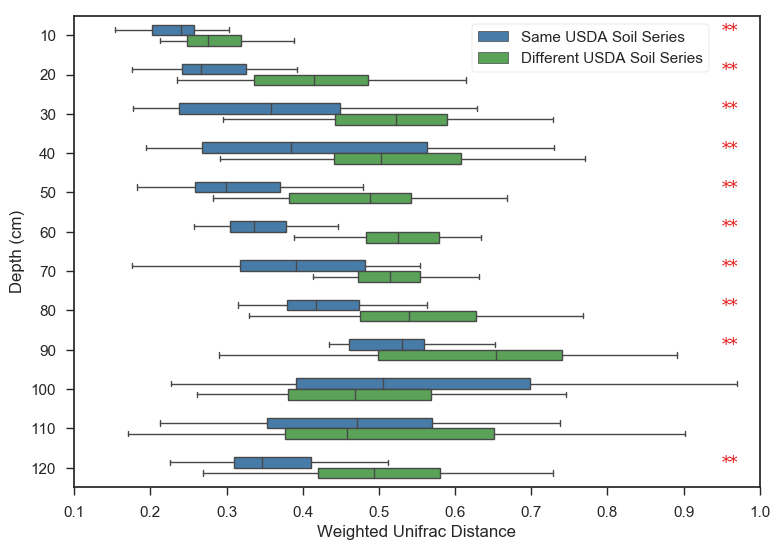

In [91]:
# Plotting depth matched BD
sns.set(font_scale=1.1)
sns.set_style({'font.sans-serif': u'Arial'})
sns.set_style('ticks')

colors = sns.color_palette('RdYlBu',5)
colors = [colors[0], colors[-1]]

f,ax1 = plt.subplots()
f.set_size_inches(8, 5.7)
sns.boxplot(ax = ax1, y="Depth (cm)", x="BD", hue="Soil", palette = new_cols[1:], data=depth_matched_df, linewidth=1, width=.55, orient='h', fliersize=0, whis=1)


ax1.legend(loc=(.58,.88), frameon=True, fancybox=True, framealpha=1)
ax1.set_xlabel('Weighted Unifrac Distance')
ax1.set_ylabel('Depth (cm)')
ax1.set_xlim([.1,1])

font = {'family': 'serif',
        'color':  new_cols[0],
        'weight': 'normal',
        'size': 12,
        }
# Adding depth paired soil-type t-test significance values:
for i in range(len(t_test_sig_05_cutoff)):
    ax1.text(.95, i, t_test_sig_05_cutoff[i], fontdict=font)


# Add means and quartiles:
#for i in range(12):
#    ax1.scatter(i-.1, same_quart[i][1],edgecolors='k',color='w',s=25, zorder=2, linewidth=.9)
#    ax1.scatter(i+.1, dif_quart[i][1],edgecolors='k',color='w',s=25, zorder=2,linewidth=.9)
#    ax1.vlines(x=i+.1, ymin=dif_quart[i][0], ymax = dif_quart[i][2], color='k', zorder=1, linewidth=1.)
#    ax1.vlines(x=i-.1, ymin=same_quart[i][0], ymax = same_quart[i][2], color='k', zorder=1, linewidth=1.)

f.tight_layout()
f.savefig("../output/beta_diversity/BD_soil_and_depth_boxplot2.png", dpi=400, bbox_inches='tight' )

In [73]:
t_test_sig_05_cutoff

['**', '**', '**', '**', '**', '**', '**', '**', '**', '', '', '**']

### Calculating ANOSIM scores for soil groupings: 

In [51]:
grouping = current_metadata.loc[current_metadata['SampleID'].isin(WUF_data.index)][['USDA_soil_series', 'SampleID']]
non_watseka_grouping = grouping.loc[grouping['USDA_soil_series'].isin(['Selma loam', 'Hoopeston fine sandy loam'])]
non_watseka_grouping.set_index('SampleID', inplace=True)

non_watseka_ind = grouping.loc[grouping['USDA_soil_series'].isin(['Selma loam', 'Hoopeston fine sandy loam'])]['SampleID']
non_watseka_df = WUF_data.loc[non_watseka_ind, non_watseka_ind]
non_watseka_dist = skbio.stats.distance.DistanceMatrix(non_watseka_df, ids=non_watseka_df.index)
anosim_scores = stats.distance.anosim(non_watseka_dist, non_watseka_grouping, column='USDA_soil_series')
print(anosim_scores)

method name                  ANOSIM
test statistic name               R
sample size                     152
number of groups                  2
test statistic            0.0108456
p-value                       0.333
number of permutations          999
Name: ANOSIM results, dtype: object


In [50]:
# full model:
full_dist_mat = stats.distance.DistanceMatrix(WUF_data, ids = WUF_data.index)
reindexed_metadata = current_metadata.set_index('SampleID')
permanova_full = stats.distance.anosim(full_dist_mat, reindexed_metadata, column='USDA_soil_series')
print(permanova_full)

method name                 ANOSIM
test statistic name              R
sample size                    222
number of groups                 3
test statistic            0.315017
p-value                      0.001
number of permutations         999
Name: ANOSIM results, dtype: object


### Old

In [ ]:
# This is not used anymore but the function docstring is so pretty. 
def offset_violinplot_halves(ax, delta, width, inner, direction):
    """
    This function offsets the halves of a violinplot to compare tails
    or to plot something else in between them. This is specifically designed
    for violinplots by Seaborn that use the option `split=True`.

    For lines, this works on the assumption that Seaborn plots everything with
     integers as the center.

    Args:
     <ax>    The axis that contains the violinplots.
     <delta> The amount of space to put between the two halves of the violinplot
     <width> The total width of the violinplot, as passed to sns.violinplot()
     <inner> The type of inner in the seaborn
     <direction> Orientation of violinplot. 'hotizontal' or 'vertical'.

    Returns:
     - NA, modifies the <ax> directly
    """
    # offset stuff
    if inner == 'sticks':
        lines = ax.get_lines()
        for line in lines:
            if direction == 'horizontal':
                data = line.get_ydata()
                print(data)
                if int(data[0] + 1)/int(data[1] + 1) < 1:
                    # type is top, move neg, direction backwards for horizontal
                    data -= delta
                else:
                    # type is bottom, move pos, direction backward for hori
                    data += delta
                line.set_ydata(data)
            elif direction == 'vertical':
                data = line.get_xdata()
                print(data)
                if int(data[0] + 1)/int(data[1] + 1) < 1:
                    # type is left, move neg
                    data -= delta
                else:
                    # type is left, move pos
                    data += delta
                line.set_xdata(data)


    for ii, item in enumerate(ax.collections):
        # axis contains PolyCollections and PathCollections
        if isinstance(item, matplotlib.collections.PolyCollection):
            # get path
            path, = item.get_paths()
            vertices = path.vertices
            half_type = _wedge_dir(vertices, direction)
            # shift x-coordinates of path
            if half_type in ['top','bottom']:
               if inner in ["sticks", None, 'quartile']:
                    if half_type == 'top': # -> up
                        vertices[:,1] -= delta
                    elif half_type == 'bottom': # -> down
                        vertices[:,1] += delta
            elif half_type in ['left', 'right', 'quartile']:
                if inner in ["sticks", None]:
                    if half_type == 'left': # -> left
                        vertices[:,0] -= delta
                    elif half_type == 'right': # -> down
                        vertices[:,0] += delta

def _wedge_dir(vertices, direction):
    """
    Args:
      <vertices>  The vertices from matplotlib.collections.PolyCollection
      <direction> Direction must be 'horizontal' or 'vertical' according to how
                   your plot is laid out.
    Returns:
      - a string in ['top', 'bottom', 'left', 'right'] that determines where the
         half of the violinplot is relative to the center.
    """
    if direction == 'horizontal':
        result = (direction, len(set(vertices[1:5,1])) == 1)
    elif direction == 'vertical':
        result = (direction, len(set(vertices[-3:-1,0])) == 1)
    outcome_key = {('horizontal', True): 'bottom',
                   ('horizontal', False): 'top',
                   ('vertical', True): 'left',
                   ('vertical', False): 'right'}
    # if the first couple x/y values after the start are the same, it
    #  is the input direction. If not, it is the opposite
    return outcome_key[result]

